In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from ctgan import CTGAN
from ctgan import load_demo
import data_describe as dd
import warnings
warnings.filterwarnings("ignore")

from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier, ExtraTreesClassifier, BaggingClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import train_test_split, cross_val_score, cross_validate, StratifiedKFold, GridSearchCV
from sklearn.metrics import make_scorer, accuracy_score, precision_score, recall_score, f1_score
from sklearn.ensemble import VotingClassifier
from sklearn.preprocessing import StandardScaler

from collections import Counter
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import PolynomialFeatures

In [2]:
data = pd.read_csv('../data/S&P 500 Real Estate 200-Day.csv')
data.rename(columns={'Unnamed: 0':'date'}, inplace=True)
data = data.sort_values(by=['date'])
data

,date,S&P 500,S&P 500 Real Estate (Sector),S&P 500 Performance (%),S&P 500 Real Estate (Sector) Performance (%),S&P 500 Real Estate (Sector) Outperform/Underperform,overall,commodities,housing,shelters,transportations
0,2002-02-11,1111.94,92.480003,19.195601,9.095206,9.095206173004811,178.500,149.000,179.000,206.300,207.300
1,2002-02-12,1107.50,91.610001,21.262222,8.671409,UNDERPERFORM,178.500,149.000,179.000,206.300,207.300
2,2002-02-13,1118.51,91.989998,19.133639,8.312726,UNDERPERFORM,178.500,149.000,179.000,206.300,207.300
3,2002-02-14,1116.48,92.470001,19.242559,8.980558,UNDERPERFORM,178.500,149.000,179.000,206.300,207.300
4,2002-02-15,1104.18,93.330002,18.153510,9.234550,UNDERPERFORM,178.500,149.000,179.000,206.300,207.300
...,...,...,...,...,...,...,...,...,...,...,...
4858,2021-11-24,4701.46,306.609985,19.548197,17.601252,UNDERPERFORM,280.126,210.452,288.259,341.963,326.397
4859,2021-11-26,4594.62,298.359985,16.437110,16.048222,UNDERPERFORM,280.126,210.452,288.259,341.963,326.397
4860,2021-11-29,4655.27,302.339996,19.324593,20.291239,OUTPERFORM,280.126,210.452,288.259,341.963,326.397
4861,2021-11-30,4567.00,295.940002,17.908879,17.707424,UNDERPERFORM,280.126,210.452,288.259,341.963,326.397


## Using all data 

In [3]:
data['date'] = pd.to_datetime(data['date'])
data['month'] = data['date'].dt.month
data['year'] = data['date'].dt.year
data['dow'] = data['date'].dt.dayofweek
data = data[data['dow']==3].groupby(['year','month']).nth[1].reset_index()
data

,year,month,date,S&P 500,S&P 500 Real Estate (Sector),S&P 500 Performance (%),S&P 500 Real Estate (Sector) Performance (%),S&P 500 Real Estate (Sector) Outperform/Underperform,overall,commodities,housing,shelters,transportations,dow
0,2002,2,2002-02-21,1080.95,91.989998,19.237770,9.173980,UNDERPERFORM,178.500,149.000,179.000,206.300,207.300,3
1,2002,3,2002-03-14,1153.04,97.040001,31.715787,18.936151,UNDERPERFORM,179.300,150.000,179.500,207.000,208.000,3
2,2002,4,2002-04-11,1103.69,99.620003,30.231982,28.029823,UNDERPERFORM,179.500,149.700,179.800,207.400,208.700,3
3,2002,5,2002-05-09,1073.01,94.000000,27.957117,16.164116,UNDERPERFORM,179.600,149.700,180.000,207.800,208.600,3
4,2002,6,2002-06-13,1009.56,97.290001,19.026622,18.285716,UNDERPERFORM,180.000,149.900,180.200,208.200,208.800,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
229,2021,7,2021-07-08,4320.82,283.359985,1.147999,-8.256168,UNDERPERFORM,273.092,201.975,281.979,335.888,326.470,3
230,2021,8,2021-08-12,4460.83,290.109985,7.276877,3.536750,UNDERPERFORM,274.214,203.215,283.532,337.298,323.329,3
231,2021,9,2021-09-09,4493.28,296.170013,15.209058,13.353496,UNDERPERFORM,276.590,206.035,285.453,338.865,323.995,3
232,2021,10,2021-10-14,4438.26,288.570007,8.483351,6.310789,UNDERPERFORM,278.524,208.467,286.849,340.475,326.256,3


In [4]:
original = data[['S&P 500 Real Estate (Sector) Outperform/Underperform','month','overall','commodities','housing','shelters','transportations']]

In [5]:
data.drop(columns=['date','S&P 500 Real Estate (Sector) Outperform/Underperform','year'], inplace=True)
data.head()

,month,S&P 500,S&P 500 Real Estate (Sector),S&P 500 Performance (%),S&P 500 Real Estate (Sector) Performance (%),overall,commodities,housing,shelters,transportations,dow
0,2,1080.95,91.989998,19.237770,9.173980,178.5,149.0,179.0,206.3,207.3,3
1,3,1153.04,97.040001,31.715787,18.936151,179.3,150.0,179.5,207.0,208.0,3
2,4,1103.69,99.620003,30.231982,28.029823,179.5,149.7,179.8,207.4,208.7,3
3,5,1073.01,94.000000,27.957117,16.164116,179.6,149.7,180.0,207.8,208.6,3
4,6,1009.56,97.290001,19.026622,18.285716,180.0,149.9,180.2,208.2,208.8,3


In [6]:
original['Performance'] = np.where(original['S&P 500 Real Estate (Sector) Outperform/Underperform'] == 'OUTPERFORM',1,0)
original = original[['Performance','month','overall','commodities','housing','shelters','transportations']]

In [7]:
dd.data_summary(original)

,Info
Rows,234
Columns,7
Size in Memory,12.9 KB


,Data Type,Nulls,Zeros,Min,Median,Max,Mean,Standard Deviation,Unique,Top Frequency
Performance,int64,0,0,0,0,1,0.44,0.50,2,130
month,int64,0,0,1,6,12,6.50,3.45,12,20
overall,float64,0,0,178.50,227.20,280.13,224.37,25.23,229,2
commodities,float64,0,0,149,179.83,210.45,175.58,13.51,221,3
housing,float64,0,0,179,220.83,288.26,226.17,28.15,232,2
shelters,float64,0,0,206.30,253.88,341.96,263.56,36.84,227,2
transportations,float64,0,0,207.30,270.18,333.37,268.78,37.51,229,2


None

data-describe Summary Widget

<AxesSubplot: title={'center': 'Correlation Matrix'}>

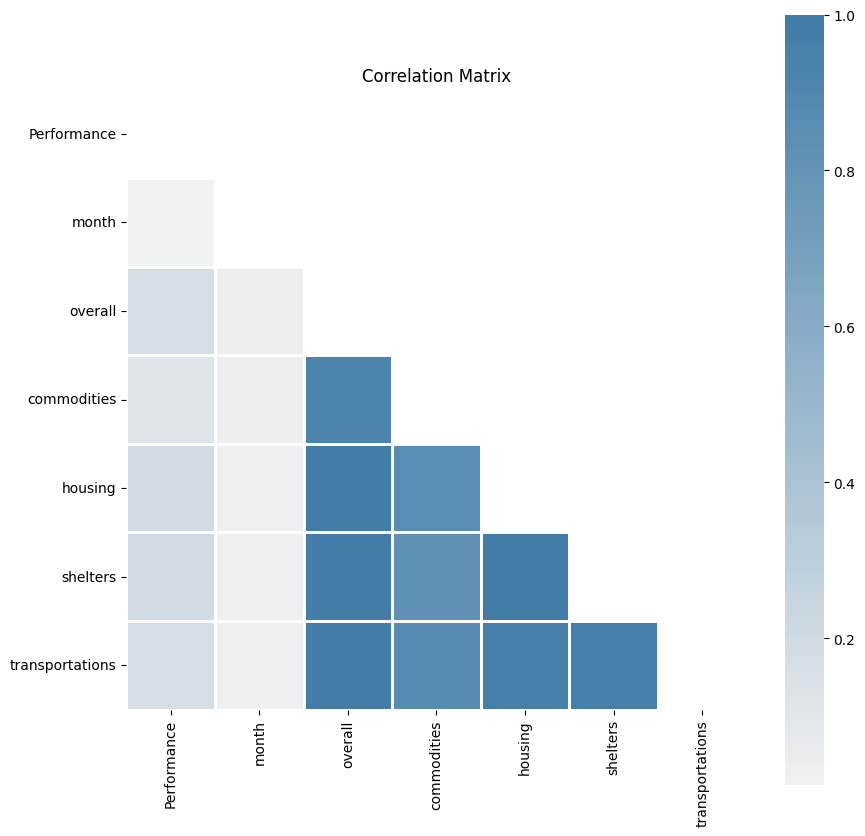

In [8]:
dd.correlation_matrix(original)

### Conditional GAN

In [9]:
discrete_columns = [
    'month'
]

ctgan = CTGAN(epochs=5000)
ctgan.fit(data, discrete_columns)

# Synthetic copy
samples = ctgan.sample(10000)
samples

,month,S&P 500,S&P 500 Real Estate (Sector),S&P 500 Performance (%),S&P 500 Real Estate (Sector) Performance (%),overall,commodities,housing,shelters,transportations,dow
0,9,1154.414615,113.821882,-9.673269,-1.459339,189.231882,159.338814,216.688013,243.237775,223.360119,3
1,4,2325.311825,221.132263,-7.996609,-1.826056,253.080465,181.546112,260.675849,301.743912,326.036899,3
2,2,1229.530723,135.740834,-20.695272,-15.597075,224.103257,186.618278,220.759462,248.957490,269.574805,3
3,1,2352.455434,189.116818,-7.284859,-3.510999,238.374621,182.948190,236.452309,279.847590,284.868270,3
4,12,1207.504990,109.381712,-6.347622,-0.028030,201.796271,163.613852,205.608564,231.441921,241.007336,3
...,...,...,...,...,...,...,...,...,...,...,...
9995,12,2547.901574,165.505448,-12.407557,-5.153833,251.595959,182.690708,268.123449,269.023045,321.090093,3
9996,6,2718.916218,171.796487,-7.783856,10.166192,236.346951,210.176375,226.925123,271.861661,290.893305,3
9997,5,882.546967,83.568447,-15.869779,-25.631063,227.432458,181.016214,223.231821,244.025927,268.400136,3
9998,6,1196.923916,140.612603,-10.304240,4.220337,193.198999,165.983496,206.588396,223.301212,226.179618,3


In [10]:
samples['Performance'] = np.where(samples['S&P 500 Real Estate (Sector) Performance (%)'] > \
                                  samples['S&P 500 Performance (%)'], 1, 0)

In [11]:
samples = samples[['Performance','month','overall','commodities','housing','shelters','transportations']]
samples.head()

,Performance,month,overall,commodities,housing,shelters,transportations
0,1,9,189.231882,159.338814,216.688013,243.237775,223.360119
1,1,4,253.080465,181.546112,260.675849,301.743912,326.036899
2,1,2,224.103257,186.618278,220.759462,248.957490,269.574805
3,1,1,238.374621,182.948190,236.452309,279.847590,284.868270
4,1,12,201.796271,163.613852,205.608564,231.441921,241.007336


In [12]:
dd.data_summary(samples)

,Info
Rows,10000
Columns,7
Size in Memory,547.0 KB


,Data Type,Nulls,Zeros,Min,Median,Max,Mean,Standard Deviation,Unique,Top Frequency
Performance,int64,0,0,0,1,1,0.56,0.50,2,5612
month,int64,0,0,1,6,12,6.54,3.45,12,875
overall,float64,0,0,164.32,228.72,292.74,224.59,26.40,9998,2
commodities,float64,0,0,133.18,180.35,220.19,174.24,13.90,10000,1
housing,float64,0,0,171.57,223.057,303.39,227.14,28.15,10000,1
shelters,float64,0,0,170.90,255.74,362.96,263.95,39.36,9999,2
transportations,float64,0,0,195.29,274.27,354.34,271.90,39.82,10000,1


None

data-describe Summary Widget

<AxesSubplot: title={'center': 'Correlation Matrix'}>

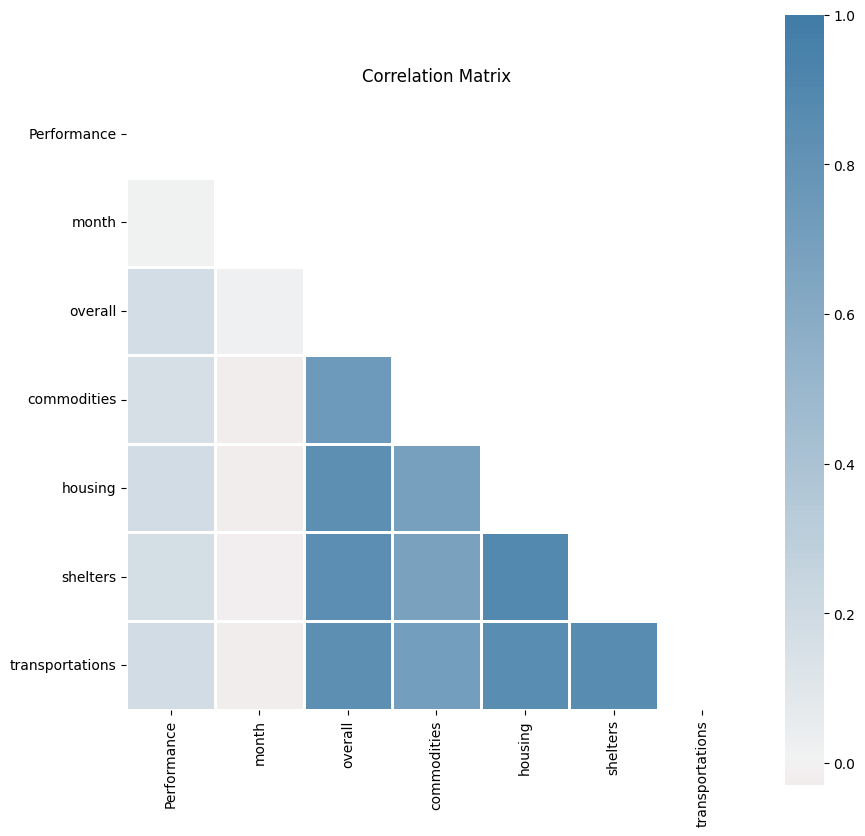

In [13]:
dd.correlation_matrix(samples)

In [14]:
X = samples.drop(['Performance'],axis=1)
y = samples['Performance']

### SMOTE Oversampling

In [15]:
counter = Counter(y)
print(counter)
oversample = SMOTE()
X, y = oversample.fit_resample(X, y)
counter = Counter(y)
print(counter)

Counter({1: 5612, 0: 4388})
Counter({1: 5612, 0: 5612})


### Interaction Terms

In [16]:
poly = PolynomialFeatures(interaction_only=True,include_bias = False)
X_poly = poly.fit_transform(X.drop(['month'],axis=1))
X_poly

array([[  189.23188249,   159.3388137 ,   216.68801313, ...,
        52706.71026971, 48399.46031791, 54329.61837056],
       [  253.08046457,   181.5461123 ,   260.6758491 , ...,
        78657.35043975, 84989.94559592, 98379.6494533 ],
       [  224.10325655,   186.61827789,   220.75946233, ...,
        54959.72152822, 59511.18898512, 67112.66666027],
       ...,
       [  239.60119279,   168.31423749,   253.07994126, ...,
        78237.0114615 , 80703.55609948, 98580.14996291],
       [  220.72942318,   187.97078353,   231.96543859, ...,
        57443.34114623, 64452.35266441, 68806.88579234],
       [  215.56468701,   180.19807869,   225.93198105, ...,
        61830.82747961, 60013.97215887, 72694.57642868]])

In [17]:
month = X['month'].to_numpy()
month = np.reshape(month,(-1,1))
X = np.append(X_poly,month,1)
X.shape

(11224, 16)

In [18]:
X_real = original.drop(['Performance'],axis=1)
y_real = original['Performance']
X_real_poly = poly.fit_transform(X_real.drop(['month'],axis=1))
month = X_real['month'].to_numpy()
month = np.reshape(month,(-1,1))
X_real = np.append(X_real_poly,month,1)
X_real.shape

(234, 16)

In [19]:
stscaler = StandardScaler().fit(X)
X = stscaler.transform(X)
X_real = stscaler.transform(X_real)

### Training with CV

In [20]:
random_state = 42
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state = random_state)
classifiers = []

classifiers.append(KNeighborsClassifier())
classifiers.append(DecisionTreeClassifier(random_state=random_state))
classifiers.append(RandomForestClassifier(random_state=random_state))
classifiers.append(AdaBoostClassifier(random_state=random_state))
classifiers.append(GradientBoostingClassifier(random_state=random_state))
classifiers.append(ExtraTreesClassifier(random_state=random_state))
classifiers.append(BaggingClassifier(random_state=random_state))
classifiers.append(SVC(random_state=random_state))
classifiers.append(GaussianNB())

k_fold = StratifiedKFold(n_splits=10)

Model_Comparison = pd.DataFrame(columns=['Name', 'CV Mean Accuracy', 'CV Mean Precision', 'CV Mean Recall',\
                                         'CV Mean F-1 Score', \
                                         'Accuracy', 'Precision', 'Recall', 'F-1 Score',\
                                        'Accuracy Real', 'Precision Real', 'Recall Real', 'F-1 Score Real'])
row = 0
for clf in classifiers:
    name = clf.__class__.__name__
    Model_Comparison.loc[row, 'Name'] = name
    
    Model_Comparison.loc[row, 'CV Mean Accuracy'] = cross_val_score(clf, X, y, scoring = 'accuracy', \
                                                                 cv = k_fold, n_jobs = 10).mean()
    Model_Comparison.loc[row, 'CV Mean Precision'] = cross_val_score(clf, X, y, scoring = 'precision',\
                                                                 cv = k_fold, n_jobs = 10).mean()
    Model_Comparison.loc[row, 'CV Mean Recall'] = cross_val_score(clf, X, y, scoring = 'recall', \
                                                                 cv = k_fold, n_jobs = 10).mean()
    Model_Comparison.loc[row, 'CV Mean F-1 Score'] = cross_val_score(clf, X, y, scoring = 'f1', \
                                                                 cv = k_fold, n_jobs = 10).mean()

    clf.fit(x_train, y_train)
    y_pred = clf.predict(x_test)
    Model_Comparison.loc[row, 'Accuracy'] = accuracy_score(y_test, y_pred)
    Model_Comparison.loc[row, 'Precision'] = precision_score(y_test, y_pred)
    Model_Comparison.loc[row, 'Recall'] = recall_score(y_test, y_pred)
    Model_Comparison.loc[row, 'F-1 Score'] = f1_score(y_test, y_pred)
    
    y_pred = clf.predict(X_real)
    Model_Comparison.loc[row, 'Accuracy Real'] = accuracy_score(y_real, y_pred)
    Model_Comparison.loc[row, 'Precision Real'] = precision_score(y_real, y_pred)
    Model_Comparison.loc[row, 'Recall Real'] = recall_score(y_real, y_pred)
    Model_Comparison.loc[row, 'F-1 Score Real'] = f1_score(y_real, y_pred)
    
    row += 1
Model_Comparison

,Name,CV Mean Accuracy,CV Mean Precision,CV Mean Recall,CV Mean F-1 Score,Accuracy,Precision,Recall,F-1 Score,Accuracy Real,Precision Real,Recall Real,F-1 Score Real
0,KNeighborsClassifier,0.616544,0.624229,0.592844,0.607741,0.617605,0.61039,0.613488,0.611935,0.5,0.446281,0.519231,0.48
1,DecisionTreeClassifier,0.591601,0.600503,0.570218,0.583661,0.573058,0.567386,0.552574,0.559882,0.602564,0.547009,0.615385,0.579186
2,RandomForestClassifier,0.656105,0.677678,0.624739,0.647032,0.650748,0.648992,0.630167,0.639441,0.564103,0.508475,0.576923,0.540541
3,AdaBoostClassifier,0.616003,0.618022,0.60764,0.612429,0.619743,0.610795,0.62364,0.617151,0.628205,0.573913,0.634615,0.60274
4,GradientBoostingClassifier,0.617519,0.621435,0.60104,0.611035,0.619031,0.615327,0.59971,0.607418,0.598291,0.55,0.528846,0.539216
5,ExtraTreesClassifier,0.673034,0.696139,0.64826,0.667355,0.659658,0.654745,0.650471,0.652601,0.542735,0.48855,0.615385,0.544681
6,BaggingClassifier,0.622693,0.656162,0.530836,0.585257,0.633286,0.650344,0.548949,0.59536,0.542735,0.488,0.586538,0.532751
7,SVC,0.60469,0.612854,0.568967,0.589986,0.600855,0.594457,0.591008,0.592727,0.636752,0.582609,0.644231,0.611872
8,GaussianNB,0.595069,0.60295,0.556497,0.578716,0.594797,0.589102,0.580131,0.584582,0.649573,0.6,0.634615,0.616822


## Using data after 2010 (Best Model)

In [22]:
data = pd.read_csv('../data/S&P 500 Real Estate 200-Day.csv')
data.rename(columns={'Unnamed: 0':'date'}, inplace=True)
data = data.sort_values(by=['date'])
data['date'] = pd.to_datetime(data['date'])
data['month'] = data['date'].dt.month
data['year'] = data['date'].dt.year
data['dow'] = data['date'].dt.dayofweek
data = data[data['dow']==3].groupby(['year','month']).nth[1].reset_index()
data = data[data['year'] >= 2010]
data

,year,month,date,S&P 500,S&P 500 Real Estate (Sector),S&P 500 Performance (%),S&P 500 Real Estate (Sector) Performance (%),S&P 500 Real Estate (Sector) Outperform/Underperform,overall,commodities,housing,shelters,transportations,dow
95,2010,1,2010-01-14,1148.46,94.040001,-2.941027,-19.035730,UNDERPERFORM,217.281,174.321,216.042,247.997,257.050,3
96,2010,2,2010-02-11,1078.47,86.949997,-9.326551,-24.535674,UNDERPERFORM,217.353,174.137,216.146,247.914,257.804,3
97,2010,3,2010-03-11,1150.24,99.019997,-8.476491,-16.810890,UNDERPERFORM,217.403,173.874,216.092,247.959,258.306,3
98,2010,4,2010-04-08,1186.44,105.040001,-7.551331,-14.670997,UNDERPERFORM,217.290,173.367,216.128,248.128,258.969,3
99,2010,5,2010-05-13,1157.44,109.879997,-12.792152,-17.265267,UNDERPERFORM,217.199,172.929,216.060,248.295,259.454,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
229,2021,7,2021-07-08,4320.82,283.359985,1.147999,-8.256168,UNDERPERFORM,273.092,201.975,281.979,335.888,326.470,3
230,2021,8,2021-08-12,4460.83,290.109985,7.276877,3.536750,UNDERPERFORM,274.214,203.215,283.532,337.298,323.329,3
231,2021,9,2021-09-09,4493.28,296.170013,15.209058,13.353496,UNDERPERFORM,276.590,206.035,285.453,338.865,323.995,3
232,2021,10,2021-10-14,4438.26,288.570007,8.483351,6.310789,UNDERPERFORM,278.524,208.467,286.849,340.475,326.256,3


In [23]:
original = data[['S&P 500 Real Estate (Sector) Outperform/Underperform','month','overall','commodities','housing','shelters','transportations']]
data.drop(columns=['date','S&P 500 Real Estate (Sector) Outperform/Underperform','year'], inplace=True)
original['Performance'] = np.where(original['S&P 500 Real Estate (Sector) Outperform/Underperform'] == 'OUTPERFORM',1,0)
original = original[['Performance','month','overall','commodities','housing','shelters','transportations']]
discrete_columns = [
    'month'
]

ctgan = CTGAN(epochs=5000)
ctgan.fit(data, discrete_columns)

# Synthetic copy
samples = ctgan.sample(10000)
samples

,month,S&P 500,S&P 500 Real Estate (Sector),S&P 500 Performance (%),S&P 500 Real Estate (Sector) Performance (%),overall,commodities,housing,shelters,transportations,dow
0,4,1366.196537,127.623276,-9.750426,2.079512,243.178978,176.480526,216.281784,291.266231,267.696558,3
1,1,1144.168392,129.211163,-3.141248,-4.520638,221.831342,182.491176,216.602066,234.413334,272.393993,3
2,1,2321.310192,141.149909,-4.561235,-3.138701,233.342321,185.498436,231.485004,261.157181,285.541815,3
3,8,1225.104633,123.328045,-14.769657,-3.226632,229.085604,186.915666,222.539853,247.978567,267.783746,3
4,1,1229.885346,116.585035,-12.677614,-16.026758,230.629146,184.354148,211.416421,239.546296,270.658623,3
...,...,...,...,...,...,...,...,...,...,...,...
9995,3,3842.066203,242.266747,-17.373308,-5.556335,264.546903,190.076172,283.225148,344.515033,335.455889,3
9996,8,2122.754343,201.583970,-13.430109,-7.596021,257.801631,183.703871,262.252776,319.368298,311.789005,3
9997,3,1927.058331,99.620853,-15.958378,2.712677,228.206765,179.742315,246.384633,255.974477,253.881795,3
9998,4,1081.509568,162.052936,-8.029331,-9.803903,226.181916,188.028295,223.472557,248.846573,281.772238,3


In [24]:
samples['Performance'] = np.where(samples['S&P 500 Real Estate (Sector) Performance (%)'] > \
                                  samples['S&P 500 Performance (%)'], 1, 0)
samples = samples[['Performance','month','overall','commodities','housing','shelters','transportations']]
X = samples.drop(['Performance'],axis=1)
y = samples['Performance']
oversample = SMOTE()
X, y = oversample.fit_resample(X, y)
poly = PolynomialFeatures(interaction_only=True,include_bias = False)
X_poly = poly.fit_transform(X.drop(['month'],axis=1))
month = X['month'].to_numpy()
month = np.reshape(month,(-1,1))
X = np.append(X_poly,month,1)
X_real = original.drop(['Performance'],axis=1)
y_real = original['Performance']
X_real_poly = poly.fit_transform(X_real.drop(['month'],axis=1))
month = X_real['month'].to_numpy()
month = np.reshape(month,(-1,1))
X_real = np.append(X_real_poly,month,1)
stscaler = StandardScaler().fit(X)
X = stscaler.transform(X)
X_real = stscaler.transform(X_real)
random_state = 42
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state = random_state)
classifiers = []

classifiers.append(KNeighborsClassifier())
classifiers.append(DecisionTreeClassifier(random_state=random_state))
classifiers.append(RandomForestClassifier(random_state=random_state))
classifiers.append(AdaBoostClassifier(random_state=random_state))
classifiers.append(GradientBoostingClassifier(random_state=random_state))
classifiers.append(ExtraTreesClassifier(random_state=random_state))
classifiers.append(BaggingClassifier(random_state=random_state))
classifiers.append(SVC(random_state=random_state))
classifiers.append(GaussianNB())

k_fold = StratifiedKFold(n_splits=10)

Model_Comparison = pd.DataFrame(columns=['Name', 'CV Mean Accuracy', 'CV Mean Precision', 'CV Mean Recall',\
                                         'CV Mean F-1 Score', \
                                         'Accuracy', 'Precision', 'Recall', 'F-1 Score',\
                                        'Accuracy Real', 'Precision Real', 'Recall Real', 'F-1 Score Real'])
row = 0
for clf in classifiers:
    name = clf.__class__.__name__
    Model_Comparison.loc[row, 'Name'] = name
    
    Model_Comparison.loc[row, 'CV Mean Accuracy'] = cross_val_score(clf, X, y, scoring = 'accuracy', \
                                                                 cv = k_fold, n_jobs = 10).mean()
    Model_Comparison.loc[row, 'CV Mean Precision'] = cross_val_score(clf, X, y, scoring = 'precision',\
                                                                 cv = k_fold, n_jobs = 10).mean()
    Model_Comparison.loc[row, 'CV Mean Recall'] = cross_val_score(clf, X, y, scoring = 'recall', \
                                                                 cv = k_fold, n_jobs = 10).mean()
    Model_Comparison.loc[row, 'CV Mean F-1 Score'] = cross_val_score(clf, X, y, scoring = 'f1', \
                                                                 cv = k_fold, n_jobs = 10).mean()

    clf.fit(x_train, y_train)
    y_pred = clf.predict(x_test)
    Model_Comparison.loc[row, 'Accuracy'] = accuracy_score(y_test, y_pred)
    Model_Comparison.loc[row, 'Precision'] = precision_score(y_test, y_pred)
    Model_Comparison.loc[row, 'Recall'] = recall_score(y_test, y_pred)
    Model_Comparison.loc[row, 'F-1 Score'] = f1_score(y_test, y_pred)
    
    y_pred = clf.predict(X_real)
    Model_Comparison.loc[row, 'Accuracy Real'] = accuracy_score(y_real, y_pred)
    Model_Comparison.loc[row, 'Precision Real'] = precision_score(y_real, y_pred)
    Model_Comparison.loc[row, 'Recall Real'] = recall_score(y_real, y_pred)
    Model_Comparison.loc[row, 'F-1 Score Real'] = f1_score(y_real, y_pred)
    
    row += 1
Model_Comparison

,Name,CV Mean Accuracy,CV Mean Precision,CV Mean Recall,CV Mean F-1 Score,Accuracy,Precision,Recall,F-1 Score,Accuracy Real,Precision Real,Recall Real,F-1 Score Real
0,KNeighborsClassifier,0.718681,0.785664,0.608636,0.684734,0.699381,0.763663,0.579921,0.659229,0.517986,0.5125,0.594203,0.550336
1,DecisionTreeClassifier,0.699764,0.71514,0.670227,0.690802,0.682227,0.692853,0.65788,0.674914,0.546763,0.5375,0.623188,0.577181
2,RandomForestClassifier,0.788714,0.838366,0.724933,0.775583,0.772497,0.812982,0.709478,0.757712,0.546763,0.529412,0.782609,0.631579
3,AdaBoostClassifier,0.648926,0.670795,0.585995,0.625335,0.6527,0.678618,0.583847,0.627676,0.553957,0.557377,0.492754,0.523077
4,GradientBoostingClassifier,0.664536,0.69511,0.587681,0.63666,0.670135,0.706081,0.586091,0.640515,0.52518,0.523077,0.492754,0.507463
5,ExtraTreesClassifier,0.823238,0.868761,0.770215,0.814691,0.800337,0.837209,0.747056,0.789567,0.568345,0.542857,0.826087,0.655172
6,BaggingClassifier,0.742377,0.810873,0.638167,0.713133,0.725816,0.786119,0.622546,0.694836,0.582734,0.564706,0.695652,0.623377
7,SVC,0.635917,0.683103,0.507524,0.582285,0.64117,0.700713,0.496354,0.58109,0.52518,0.529412,0.391304,0.45
8,GaussianNB,0.626073,0.655119,0.532979,0.587739,0.622328,0.654712,0.522154,0.580967,0.532374,0.538462,0.405797,0.46281


### Voting Classifier

In [25]:
et_clf = ExtraTreesClassifier(random_state=random_state)
bag_clf = BaggingClassifier(random_state=random_state)
rf_clf = RandomForestClassifier(random_state=random_state)
classifiers = [('RF', rf_clf), \
               ('ET', et_clf),\
              ('Bagging', bag_clf)]

vc = VotingClassifier(estimators = classifiers, voting = 'soft')     
vc.fit(x_train, y_train)
y_pred = vc.predict(x_test)
vc_res = pd.DataFrame(columns=['Accuracy', 'Precision', 'Recall', 'F-1 Score'])
vc_res.loc[0, 'Accuracy'] = accuracy_score(y_test, y_pred)
vc_res.loc[0, 'Precision'] = precision_score(y_test, y_pred)
vc_res.loc[0, 'Recall'] = recall_score(y_test, y_pred)
vc_res.loc[0, 'F-1 Score'] = f1_score(y_test, y_pred)
vc_res

,Accuracy,Precision,Recall,F-1 Score
0,0.784871,0.821745,0.729108,0.77266
